In [50]:
import sys
sys.path.append('../') # To import from parent dir
import time
import os
import ast
import re

import pandas as pd
import numpy as np
from itertools import chain

import util.GrammarBasedUtil as grammar_util
import util.ui_stump as ui_stump

import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

In [51]:
# The log with the first True value will be processed
# So set one "is____ = True" and all others to False
# For Action Logger you can choose between Leno Sequential (SRRT+) or Mixed (SRRT||)

# ---- Define if you want to process a sample Smart RPA Log ----
isSmartRPA = False
log_name_smartRPA = "LenLog_1_1_10_25_5_5000.csv"

# ---- Leno Sequential Log ----
isActionLogger = True
leno_plus = False

# ---- Real World Test Recording Author ----
isRealWorldTest = False

# ---- HCI Based Log ----
# Set True if a HCI Log should be processed
isHCI = False


#       ####                                        ####
#       ####                                        ####
#       ####                                        ####
#       ####    After Setting the top parameters    ####
#       ####    you can start all cells with the    ####
#       ####    Notebook function ">> Run All".     ####
#       ####                                        ####
#       ####                                        ####
#
#       ####                                        ####
#       ####                                        ####

### Data Preperation

Depending on the selection before in cell 2 of this notebook, the following code prepares the data to make the notebook run smooth.
If a new log should be process-able, the preprocessing has to be added here.


The following data is prepared for processing
1. The Context parameter levels according to the UI hierarchy reference model
   1. Each hierarchy level as an individual list
   2. hierarchy_list: A list of lists
   3. hierarchy_columns: A flattend (concatenated) list of the context parameters
2. The Ground Truth for Experiment comparison (Dataframe with columns: start_index, end_index, length)
3. CSV Read of the log(s)


### Dataset Sources:

#### SmartRPA
Source: https://zenodo.org/records/6518291
Creation of noisy data as defined in: 04_validationLogCreation.ipynb

#### Leno
Source: https://figshare.com/articles/dataset/UI_logs/12543587/4
Extension with noise from Hohenadl: https://link.springer.com/chapter/10.1007/978-3-032-02936-2_20

#### HCI
Source: https://springernature.figshare.com/collections/A_dataset_of_human-machine_interactions_for_a_smarter_UX/6612805

Setup of Data and reading of necessary files for SmartRPA validation

In [ ]:
# Create Standard Based data for both logs, so that all down stream measures look the same

# 1. Dataframe mit Start Index, Length, End_Index
# 2. Context Parameters
#   2.2. All levels initiated
#   2.1. Flatten hierarchy_columns
# 3. Read Files


# ground_truth => Dataframe with columns: caseid, start_index, length, end_index
# log => Dataframe with all events symbolized according to hierarchy_columns
# hierarchy_columns => List of Lists with all hierarchy levels used for symbolization
# hierarchy_list => Flattened list of hierarchy_columns

if isSmartRPA or isRealWorldTest:

    # Note: Read the alignment hints above
    systems = ["category"]
    applications = ["application"]
    uiGroup1 = ["workbook","browser_url","title"]
    uiGroup2 = ["current_worksheet"] 
    uiGroup3 = ["cell_range","cell_range_number"]
    uiElement = ["mouse_coord","tag_category","xpath","event_src_path","event_dest_path","tag_name","tag_title","tag_href",
                "tag_innerText","tab_pinned","tab_audible","tab_muted","window_ingognito","tab_moved_from_index","tab_moved_to_index","id"]
    actions = ["concept:name","eventQual"]
    # ---- Add all hierarchy levels into a list ----
    hierarchy_list_smartrpa = [systems, applications, uiGroup1, uiGroup2, uiGroup3, uiElement, actions]
    hierarchy_columns_smartrpa = list(chain.from_iterable([h for h in hierarchy_list_smartrpa if h]))

    hierarchy_list = hierarchy_list_smartrpa
    hierarchy_columns = hierarchy_columns_smartrpa

    sep_smartrpa = ","
    if isSmartRPA:
        # ---- Define folder path and relevant files ----
        folder_path_smartRPA = "../logs/smartRPA/percentageComparison/"
        percentagData_filename = "validationDataPercentage.csv"
        # ---- Getting the relevant files from the folder and sorting them into different lists for processing ----
        percentageLogs = []

        for file in os.listdir(folder_path_smartRPA):
            if file.startswith("LenLog"):
                percentageLogs.append(file)

        # Check if data created for percentage based comparison is available
        try:
            percentageValData = pd.read_csv(folder_path_smartRPA + percentagData_filename)
            percentageValAvailable = True
        except FileNotFoundError as e:
            print(f"Could not read {percentagData_filename} from the folder.\n{e}")
            percentageValAvailable = False
        # ---- Read the relevant log file ----
        file = pd.read_csv(folder_path_smartRPA + log_name_smartRPA, sep=sep_smartrpa)
        log = grammar_util.symbolize_UILog(file, hierarchy_columns)
        print(f"Processing file: {log_name_smartRPA} with {len(log)} events.")
        comparisonVariables = percentageValData.loc[percentageValData['uiLogName'] == log_name_smartRPA]
        insertSpots = comparisonVariables["motifSpots"]
        parsed_spots = insertSpots.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        insert_spots_flat = [int(i) for sublist in parsed_spots for i in sublist]
        insert_spots_set = set(insert_spots_flat)
        print(f"{len(insert_spots_set)} insertion spots.")
        columns = ["caseid", "start_index", "length", "end_index"]
        ground_truth = pd.DataFrame(columns=columns)
        i = 0
        for insert_spot in insert_spots_set:
            ground_truth.loc[len(ground_truth)] = [i, insert_spot, comparisonVariables["motifLength"].iloc[0], insert_spot + comparisonVariables["motifLength"].iloc[0]]
            i += 1
    elif isRealWorldTest:
        folder_path_realworld = "../logs/Banking/"
        realworld_log_name = "RunningExampleSmartRPA_Anonymized.csv"
        file = pd.read_csv(folder_path_realworld + realworld_log_name, sep=";")
        log = grammar_util.symbolize_UILog(file, hierarchy_columns)
        print(f"Processing file: {realworld_log_name} with {len(log)} events.")

        ground_truth = pd.DataFrame(columns=["caseid", "start_index", "length", "end_index"])
        # Manually define ground truth based on known inserted motifs
        ground_truth.loc[len(ground_truth)] = [0, 291, 55, 346]
        ground_truth.loc[len(ground_truth)] = [1, 1229, 52, 1281]
        ground_truth.loc[len(ground_truth)] = [2, 1508, 36, 1544]
        ground_truth.loc[len(ground_truth)] = [3, 2330, 35, 2365]
        ground_truth.loc[len(ground_truth)] = [4, 2662, 33, 2695]
        ground_truth.loc[len(ground_truth)] = [5, 2712, 40, 2752]
        ground_truth.loc[len(ground_truth)] = [6, 2764, 37, 2801]
        ground_truth.loc[len(ground_truth)] = [7, 2923, 45, 2968]
elif isActionLogger:
    folder_path_leno = "../logs/leno/"
    sep_leno = ";"

    systems = []
    applications = ["targetApp"]
    uiGroup1 = ["url","target.workbookName"]
    uiGroup2 = ["target.sheetName"]
    uiElement = ["target.id","target.tagName","target.type","target.name","target.href"]
    actions = ["eventType"]
    hierarchy_list_leno = [applications, uiGroup1, uiGroup2, uiElement, actions]
    # Flatten the hierarchy list and remove empty lists
    hierarchy_list = hierarchy_list_leno
    hierarchy_columns = list(chain.from_iterable([h for h in hierarchy_list_leno if h]))
    if leno_plus: # Leno Log Sequential
        leno_SR_RT_plus = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus.csv", sep=sep_leno)
        leno_SR_RT_plus_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_plus_ground_truth.csv")
        insert_spots_set_SR_RT_plus = leno_SR_RT_plus_ground_truth["start_index"].astype(int).tolist()
        leno_SR_RT_plus_ground_truth["end_index"] = 0
        leno_SR_RT_plus_ground_truth["end_index"] = leno_SR_RT_plus_ground_truth["start_index"] + leno_SR_RT_plus_ground_truth["length"]
        ground_truth = leno_SR_RT_plus_ground_truth
        log = grammar_util.symbolize_UILog(leno_SR_RT_plus, hierarchy_columns)
    else: # Leno Log Parallel
        leno_SR_RT_parallel = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel.csv", sep=sep_leno)
        leno_SR_RT_parallel_ground_truth = pd.read_csv(folder_path_leno + "2509_extended_SR_RT_parallel_ground_truth.csv")
        insert_spots_set_SR_RT_parallel = leno_SR_RT_parallel_ground_truth["start_index"].astype(int).tolist()
        leno_SR_RT_parallel_ground_truth["end_index"] = 0
        leno_SR_RT_parallel_ground_truth["end_index"] = leno_SR_RT_parallel_ground_truth["start_index"] + leno_SR_RT_parallel_ground_truth["length"]
        ground_truth = leno_SR_RT_parallel_ground_truth
        log = grammar_util.symbolize_UILog(leno_SR_RT_parallel, hierarchy_columns)
elif isHCI:
    system = ["machine"]
    uiElement = ["idUIelement"]
    actions = ["idUIaction"]
    hierarchy_list_hci = [system, uiElement, actions]
    hierarchy_columns_hci = list(chain.from_iterable([h for h in hierarchy_list_hci if h]))
    hierarchy_list = hierarchy_list_hci
    hierarchy_columns = hierarchy_columns_hci

    folder_path_HCI = "../logs/datasetForSmarterUX/"
    hci_log_name = "raw_interactions.csv"
    hci_ground_truth_name = "sequences_df_prep_EN.csv"

    hci_log = pd.read_csv(folder_path_HCI + hci_log_name, sep=";")
    hci_ground_truth = pd.read_csv(folder_path_HCI + hci_ground_truth_name, sep=",")
    # Split the idUIelement into element and action
    hci_log[["idUIelement", "idUIaction"]] = hci_log["idUIelement"].str.extract(r'([A-Za-z]+[0-9]+)(.*)', expand=True)
    ground_truth = pd.DataFrame(columns=["motif_id", "start_index", "length", "end_index", "discovery_count"])
    for idx, row in hci_ground_truth.iterrows():
        start_index = hci_log.index[hci_log["epoch"] == row["initepoch"]][0]
        end_index = hci_log.index[hci_log["epoch"] == row["endepoch"]][0]
        length = end_index - start_index +1
        discovery_count = 1
        ground_truth.loc[len(ground_truth)] = [idx, start_index, length, end_index, discovery_count]
        
    log = grammar_util.symbolize_UILog(hci_log, hierarchy_columns)

# ---- Time the original implementation ----
encoding_df, symbols, two_gram_df = grammar_util.re_pair(log)
last_entry = len(encoding_df["new_symbol"])-1
last_encoding = encoding_df["new_symbol"].iloc[last_entry]
print("\n Last Encoded Entry: ",last_encoding)
decoded_symbol = grammar_util.re_pair_decode_symbol(last_encoding, encoding_df, printing=True)

47  unique pairs found so far. Rule-Level:  1
63  unique pairs found so far. Rule-Level:  2
71  unique pairs found so far. Rule-Level:  3
74  unique pairs found so far. Rule-Level:  4

 Last Encoded Entry:  bv
bv → (bm, bs)
  bm → (VY, ay)
    VY → [base symbol]
    ay → (t, e)
      t → (VX, WA)
        VX → [base symbol]
        WA → [base symbol]
      e → (VZ, WC)
        VZ → [base symbol]
        WC → [base symbol]
  bs → (bc, ao)
    bc → (g, am)
      g → (WB, WE)
        WB → [base symbol]
        WE → [base symbol]
      am → (WD, VS)
        WD → [base symbol]
        VS → [base symbol]
    ao → (VT, VW)
      VT → [base symbol]
      VW → [base symbol]

Decoding path for symbol 'bv':
Final expansion: ['VY', 'VX', 'WA', 'VZ', 'WC', 'WB', 'WE', 'WD', 'VS', 'VT', 'VW']



### Density Count

Areas with a high rule density refer to repetitive patterns in the UI logs. 
Thus, we calculate the Density Rule Count for the log based on the encoding_df and the previously calculated re-pair grammar.

Furthermore, the code plots the density curve based on available ground truth start information to visualize the rule density count pattern.

The first plot is the first motif from the ground truth list.
The second plot shows the plot for all ground truth motifs overlapping.

Exec. Time with loops: 3.054 seconds
Start Index of the first ground truth motif: 0


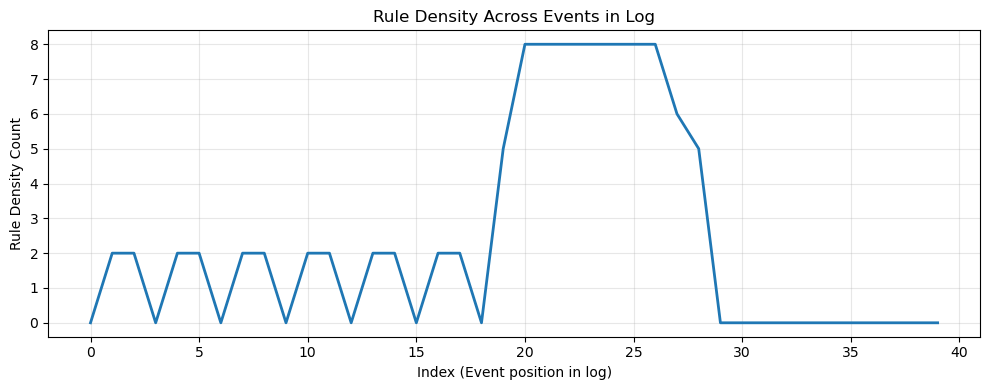

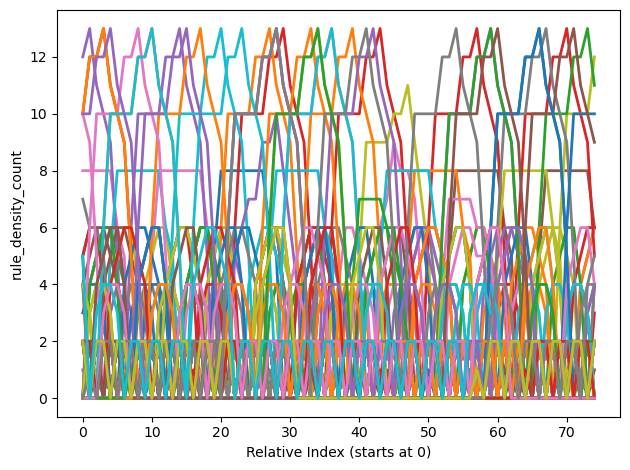

In [53]:
# ---- Initialize the count column ----
start_time = time.time()
log = grammar_util.generate_density_count(encoding_df, log)
end_time = time.time()
print(f"Exec. Time with loops: {end_time - start_time:.3f} seconds")
motiv = int(ground_truth.iloc[0]["start_index"])
print(f"Start Index of the first ground truth motif: {motiv}")
grammar_util.plot_density_curve(log, range_low=motiv, range_high=motiv+40)

colors = plt.cm.tab10.colors
length = ground_truth["length"].max()
for i, start in enumerate(ground_truth["start_index"]):
    end = start+length+10
    y = log.iloc[start:end]["rule_density_count"].to_numpy()
    x = range(len(y))  # all start at 0
    plt.plot(x, y, color=colors[i % len(colors)], linewidth=2, label=f"Range {start}-{end}")

plt.xlabel("Relative Index (starts at 0)")
plt.ylabel("rule_density_count")
plt.tight_layout()
plt.show()

### Info

Through our extension with multiple logs (HCI, SmartRPA, Leno), we found that a threshold of 0.8 is good for F1-score and precision.
Decreasing the score will lead to a high variety of motifs that are not covered through grammar rules.

Maximum rule density count: 13
Longest identified motif length: 4

intersection_ratio: 0.678
intersection_abs: 2.711
undercount_ratio: 0.980
undercount_abs: 46.410
over_detection_ratio: 0.322
over_detection_abs: 1.132

Precision: 0.684, Recall: 0.260, F1: 0.377


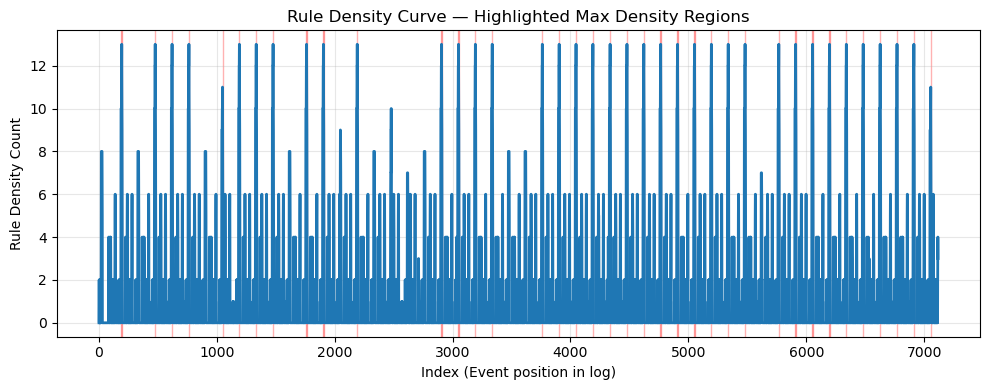

In [ ]:
max_rule_density_count, max_groups = grammar_util.find_max_density_groups(log,relative_threshold=0.8)

print(f"Maximum rule density count: {max_rule_density_count}")
max_length = -1
min_length = len(log)
for motif in max_groups:
    if len(motif) > max_length:
        max_length = len(motif)
    if len(motif) > 0 and len(motif) < min_length:
        min_length = len(motif)
print(f"Longest identified motif length: {max_length}\n")

# >> Wie finden wir jetzt von diesem Punkt aus die richtige Länge an Motifen im Datensatz? 
# Die Punkte haben wir

# Return Sample:
# [{'insert_range': (54.0, 85.0), 'density_range': (77, 81)},
#  {'insert_range': (164.0, 195.0), 'density_range': (187, 191)},
overlaps = grammar_util.find_overlaps(max_groups, ground_truth)


stats = grammar_util.motif_overlap_metrics(max_groups, ground_truth)
for key, value in stats.items():
    print(f"{key}: {value:.3f}")

# Version with over counting as two overlaps could span a single ground truth
# Especially occurring with longer motifs
tp = len(overlaps)                      # true positives = overlapping ranges
fp = len(max_groups) - tp               # predicted but not in ground truth
fn = len(ground_truth) - tp             # missed ground truth ranges

matched, tp, fp, fn, gt1 = grammar_util.match_motifs_to_gt(max_groups, ground_truth)

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


# ---- Plotting the results ----
plt.figure(figsize=(10, 4))
plt.plot(log.index, log["rule_density_count"], linewidth=2)
for g in max_groups:
    plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
plt.title("Rule Density Curve — Highlighted Max Density Regions")
plt.xlabel("Index (Event position in log)")
plt.ylabel("Rule Density Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# grammar_util.test_multi_threshold_scores(ground_truth,log)

### Motif Discovery Extension

Extend the motifs from the rules discovered to identify real start and end

Todo:

1. For Loop discard if the distance of the og measure is too high > threshold
2. Identify same patterns first, and then only extend for those that are similar enough

### Motif Clustering and Extension

The distance Matrix D takes all discovered max_groups from the rule density curve.
Afterwards the matrix is clustered to find similar motifs, if existsing.
Then for each cluster the motifs are extended to find the longest similar patterns.


In [55]:
# Convert the max_groups into a dataframe for processing
max_groups_df = pd.DataFrame(columns=["group","processed"])
max_groups_df["group"] = max_groups
max_groups_df["processed"] = False

# Paths Encoding >> Results in Unique Paths
paths = ui_stump.build_paths_from_df(log, hierarchy_list)

# Generates level encodings for fast comparision, and symbol_of_path to map back to paths from df
symbol_of_path, levels = ui_stump.build_levels_table(paths, n=len(hierarchy_list))

# Weights per Hierarchy Level
weights = ui_stump.hierarchy_weights(len(hierarchy_list))

# Generate the encoded ids for each path in the log
T_ids = ui_stump.encode_series(paths, symbol_of_path)

In [ ]:
D = ui_stump.motif_cross_distance_matrix(symbol_of_path, paths, levels, weights, max_groups)
print(D)
# ---- Generate Clusters ----
# Convert full distance matrix to condensed form (1D)
condensed = squareform(D, checks=False)

# Perform hierarchical clustering (average linkage usually works well)
Z = linkage(condensed, method='average')

# Cut the tree at a distance threshold
threshold = 0.2   # adjust depending on your distance scale
clusters = fcluster(Z, t=threshold, criterion='distance')

clustered = {}
for idx, cid in enumerate(clusters):
    clustered.setdefault(cid, []).append(idx)

# Turn into list of clusters 
clusters_list = list(clustered.values())

# Map back the clusters to the indexes of the max_groups to then extend them
cluster_groups = [[max_groups[i] for i in cluster] for cluster in clusters_list]

# If motifs in a cluster are of different lenth, we first need to align them based
# on the similarity of their start positions. Afterwards we can extend them
# based on the aligned positions

####
#### TODO
####
#### TODO
####
#### TODO
####


# 1. For each cluster find the motif with the longest length
# 2. Align all other motifs to this motif based on start position similarity   

# Cluster describing the offset matrix
# O = np.zeros((len(D), len(D)), dtype=float)
# for cluster in cluster_groups:
#     # Find the motif with the longest length
#     longest_motif = max(cluster, key=len)
#     longest_length = len(longest_motif)
#     idx_longest = cluster.index(longest_motif)
#     print(f"\nProcessing cluster with {len(cluster)} motifs, longest length: {longest_length}")
#     print(f"Longest Motif Index in Cluster: {idx_longest}, Motif: {longest_motif}")
#     # Align other motifs to the longest motif
#     for i, motif in enumerate(cluster):
#         if D[idx_longest][i] == 0:
#             O[idx_longest][i] = 0
#             O[i][idx_longest] = 0
#             continue # Skip if perfect match
#         # Here you would implement the alignment logic based on similarity
#         offset = 0  # Placeholder for actual offset calculation
#         if motif != longest_motif:
#             print(f"Aligning motif {motif} to longest motif {longest_motif} with offset {offset}")
#             distance = D[idx_longest][i]

#             distance_minus1 = ui_stump.motif_distance_with_offset(
#                 symbol_of_path, paths, levels, weights,
#                 longest_motif, motif)
#         # For simplicity, we just print the offset
# # ---- Extend Clusters till longest matches found ----


# # ---- Optional: Remove all motifs from the log, recompute rules and rerun, concat results if the extend existing motifs

# # ---- Return all motifs discovered as clusters ----

[[0.         0.         0.         ... 0.         0.         1.33333333]
 [0.         0.         0.         ... 0.         0.         1.33333333]
 [0.         0.         0.         ... 0.         0.         1.33333333]
 ...
 [0.         0.         0.         ... 0.         0.         1.33333333]
 [0.         0.         0.         ... 0.         0.         1.33333333]
 [1.33333333 1.33333333 1.33333333 ... 1.33333333 1.33333333 0.        ]]

Processing cluster with 36 motifs, longest length: 4
Longest Motif Index in Cluster: 0, Motif: [191, 192, 193, 194]
Aligning motif [1189, 1190, 1191, 1192] to longest motif [191, 192, 193, 194] with offset 0
Distance to longest motif: 1.333

Processing cluster with 2 motifs, longest length: 1
Longest Motif Index in Cluster: 0, Motif: [1048]


### Example Work

Takes the first two discovered motifs and extends their length based on similarity going up and down.

In [81]:
TA = np.array(max_groups[25], dtype=int)
TB = np.array(max_groups[26], dtype=int)

print(TA)
print(TB)
d = ui_stump.motif_distance_uihe_groups(TA, TB, symbol_of_path, paths, levels, weights)


# Calculate a threshold for extension based on the weighted levels
# Consider if the value should be based on the application level instead of a fixed 25% of weights
percentil = int(round(len(weights)-len(weights)*0.25,0))

distance_og = np.mean(d)

threshold = distance_og + weights[percentil]

while(True): # Do While Distance does not increase or get smaller: Lower Bound
    # Check for out of bounds
    if ([TA[0]-1][0] < 0) or ([TB[0]-1][0] < 0):
        break
    # Go Backwards one step
    newTA = [TA[0]-1][0]
    newTB = [TB[0]-1][0]
    level_a = levels[symbol_of_path[paths[newTA]]]
    level_b = levels[symbol_of_path[paths[newTB]]]
    measure = ui_stump.uihe_distance_non_njit(level_a, level_b, weights)
    if measure <= threshold:
        d.append(measure)
        TA = np.concatenate([[newTA],TA])
        TB = np.concatenate([[newTB],TB])
        print(f"Go Down - New Distance: {distance_og}")
    else:
        break


# Logic to cover different length by extending the shorter one first
while(True): # Do While Distance does not increase or get smaller: Upper Bound
    # Check for out of bounds
    if ([TA[(len(TA)-1)]+1][0] >= len(log)) or ([TB[(len(TB)-1)]+1][0] >= len(log)):
        break
    # Go Forwards one step on TB
    if len(TA) > len(TB):
        newTB = [TB[(len(TB)-1)]+1][0]
    # Go Forwards one step on TA
    elif len(TB) > len(TA):
        newTA = [TA[(len(TA)-1)]+1][0]
    else: # Same Length
        newTA = [TA[(len(TA)-1)]+1][0]
        newTB = [TB[(len(TB)-1)]+1][0]
    level_a = levels[symbol_of_path[paths[newTA]]]
    level_b = levels[symbol_of_path[paths[newTB]]]
    measure = ui_stump.uihe_distance_non_njit(level_a, level_b, weights)
    print(measure)
    # Allow for low level distance increases on lowest quarter of levels
    if measure <= threshold:
        if len(TA) > len(TB):
            TB = np.concatenate([TB,[newTB]])
        elif len(TB) > len(TA):
            TA = np.concatenate([TA,[newTA]])
        else: # Same Length
            TA = np.concatenate([TA,[newTA]])
            TB = np.concatenate([TB,[newTB]])
        d.append(measure)
        print(f"Go - Up New Distance: {distance_og}")
    else:
        break

print(f"First motif with {len(TA)} is at indexes {TA}")
print(f"Second motif with {len(TB)} is at indexes {TB}")
print(f"Their mean distances: {np.mean(d)}")

[5193 5194 5195 5196]
[5336 5337 5338 5339]
Go Down - New Distance: 0.0
Go Down - New Distance: 0.0
Go Down - New Distance: 0.0
Go Down - New Distance: 0.0
Go Down - New Distance: 0.0
0.0
Go - Up New Distance: 0.0
0.0
Go - Up New Distance: 0.0
0.0
Go - Up New Distance: 0.0
9.4
First motif with 12 is at indexes [5188 5189 5190 5191 5192 5193 5194 5195 5196 5197 5198 5199]
Second motif with 12 is at indexes [5331 5332 5333 5334 5335 5336 5337 5338 5339 5340 5341 5342]
Their mean distances: 0.0
